In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from models import *

In [2]:
AAPL = pd.read_csv("hist_data/AAPL.csv")
MSFT = pd.read_csv("hist_data/MSFT.csv")

q = 0.01
start = 0
begin = 365
end = None
evaluation_step = 7
simulation_steps = 30
simulations = 1000

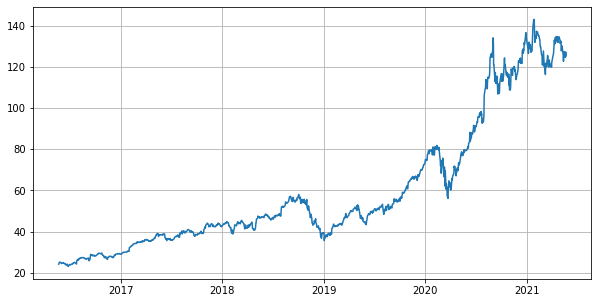

In [4]:
RS = MB_BHS(AAPL, 10)

RS.plot()

Смещающееся окно (в первом случае) имеет ширину 365

In [5]:
print("VaR violation rate (window=True): ",RS.evaluate(start, begin, end, evaluation_step, q, simulation_steps, simulations, window=True))
print("VaR violation rate (window=False): ",RS.evaluate(start, begin, end, evaluation_step, q, simulation_steps, simulations, window=False))

VaR violation rate (window=True):  0.056451612903225805
VaR violation rate (window=False):  0.06451612903225806


Последняя выполненная симуляция для AAPL

2021-04-06 2021-05-19 30


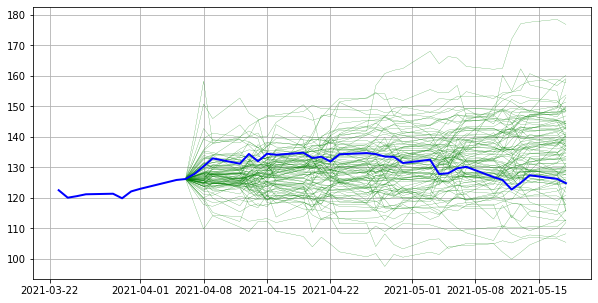

In [9]:
RS.plot_last_simulation(100, real_price=True)

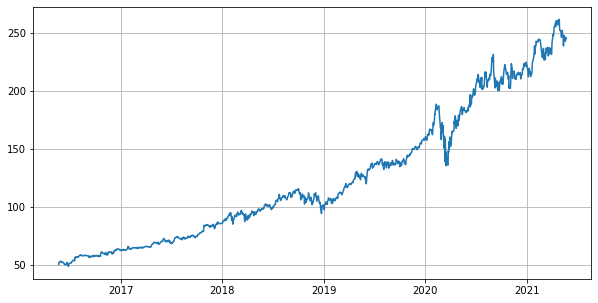

In [10]:
RS = Stationary(MSFT)
RS.plot()

Смещающееся окно (в первом случае) имеет ширину 365

In [11]:
print("VaR violation rate (window=True): ",RS.evaluate(start, begin, end, evaluation_step, q, simulation_steps, simulations, window=True))
print("VaR violation rate (window=False): ",RS.evaluate(start, begin, end, evaluation_step, q, simulation_steps, simulations, window=False))

VaR violation rate (window=True):  0.008064516129032258
VaR violation rate (window=False):  0.008064516129032258


Последняя выполненная симуляция для MSFT

2021-04-06 2021-05-19 30


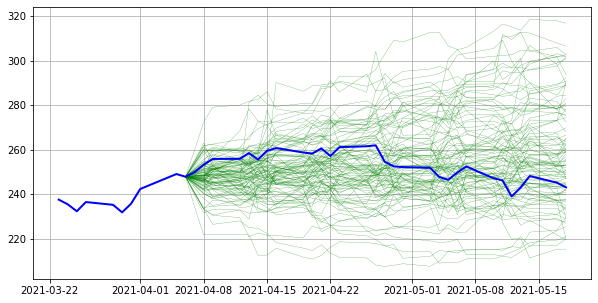

In [12]:
RS.plot_last_simulation(100, real_price=True)